In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

import seaborn as sns
sns.set_theme()

import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import linear_model
from sklearn.cluster import KMeans

In [2]:
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
cpcbColumns = ['pm2_5', 'pm10']

def getRawData():
    allData = "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/db.csv"
    densityStatsOnly = "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/densityStats.csv"
    sensorData = pd.read_csv(allData,sep=',')
    densityStats = pd.read_csv(densityStatsOnly,sep=',') 
    
    cpcbLinks = [
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/naja_pollutants.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/naja_meter.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/okla_pollutants.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/okla_meter.csv"
    ]

    okla_pollutants = pd.read_csv(cpcbLinks[2],sep=',')
    okla_meter = pd.read_csv(cpcbLinks[3],sep=',')
    naja_pollutants = pd.read_csv(cpcbLinks[0],sep=',')
    naja_meter = pd.read_csv(cpcbLinks[1],sep=',')
    
    return sensorData,okla_pollutants,okla_meter,naja_pollutants,naja_meter

def combineCPCB(okla_pollutants,okla_meter,naja_pollutants,naja_meter):
    okla_cpcb = pd.merge(okla_pollutants, okla_meter, on='To Date', how='outer')
    naja_cpcb = pd.merge(naja_pollutants, naja_meter, on='To Date', how='outer')
    
    naja_cpcb = naja_cpcb.rename(columns={'To Date': 'timestamp', 'PM2.5': 'pm2_5','PM10': 'pm10'})
    okla_cpcb = okla_cpcb.rename(columns={'To Date': 'timestamp', 'PM2.5': 'pm2_5','PM10': 'pm10'})
    
    for i in cpcbColumns:
        naja_cpcb[i] = pd.to_numeric(naja_cpcb[i], errors='coerce')
        okla_cpcb[i] = pd.to_numeric(okla_cpcb[i], errors='coerce')
    cpcbData = {"najafgarh":naja_cpcb,"okhla":okla_cpcb}
    return cpcbData
    
def partDataByLoc(sensorData,cpcbData):
    allData = {}
    for loc in sensorlocations:
        allData[loc] = sensorData[sensorData["location"]==loc].copy()
    allData["najafgarh"] = cpcbData["najafgarh"]
    allData["okhla"] = cpcbData["okhla"]
    return allData

def convertTimeStamp(allData):
    format="%m/%d/%Y"
    for location in sensorlocations:
        allData[location]['timestamp'] = (allData[location]["timestamp"].apply(lambda d: pd.to_datetime(str(d))))
        allData[location] = allData[location].sort_values(by='timestamp',ascending=True)
        allData[location] = allData[location].set_index('timestamp')
        allData[location]["timestamp"] = allData[location].index
    for location in cpcbLocations:
        allData[location]['timestamp'] = pd.to_datetime(allData[location]['timestamp'],dayfirst=True)
        allData[location] = allData[location].sort_values(by='timestamp',ascending=True)
        allData[location] = allData[location].set_index('timestamp')
        allData[location]["timestamp"] = allData[location].index
    return allData

### Get Raw Data (download step, run once only)

In [3]:
sensorData,okla_pollutants,okla_meter,naja_pollutants,naja_meter = getRawData()

### Everything below OK

In [4]:
cpcbData = combineCPCB(okla_pollutants,okla_meter,naja_pollutants,naja_meter)
allData = partDataByLoc(sensorData,cpcbData)
allData = convertTimeStamp(allData)

### Run Once Only

In [5]:
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]

def getIntForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    return (timeFromStart) / 24.0
def getFractionalDayForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    fractionDay = (timeFromStart) / 24.0
    if(row["timestamp"].month==10):
        return row["timestamp"].day + fractionDay
    else:
        return 31.0 + row["timestamp"].day + fractionDay
    
for locs in allLocations:
    allData[locs].loc[:,"integerTime"] = allData[locs].apply(lambda row: getIntForTimeDate(row), axis=1)
    allData[locs].loc[:,"fractionalDay"] = allData[locs].apply(lambda row: getFractionalDayForTimeDate(row), axis=1)

In [91]:
allData["Jharoda_Kalan"]["integerTime"]*24.0

timestamp
2021-10-02 18:01:26+05:30    18.016667
2021-10-02 18:01:56+05:30    18.016667
2021-10-02 18:02:27+05:30    18.033333
2021-10-02 18:02:30+05:30    18.033333
2021-10-02 18:02:57+05:30    18.033333
                               ...    
2021-11-07 23:57:48+05:30    23.950000
2021-11-07 23:58:18+05:30    23.966667
2021-11-07 23:58:49+05:30    23.966667
2021-11-07 23:59:20+05:30    23.983333
2021-11-07 23:59:50+05:30    23.983333
Name: integerTime, Length: 73935, dtype: float64

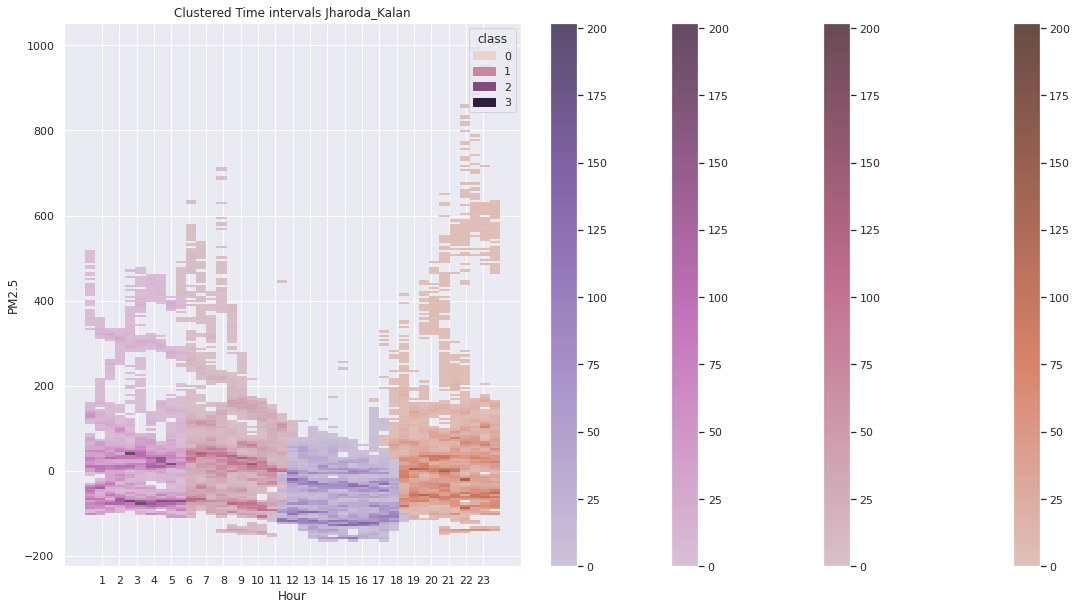

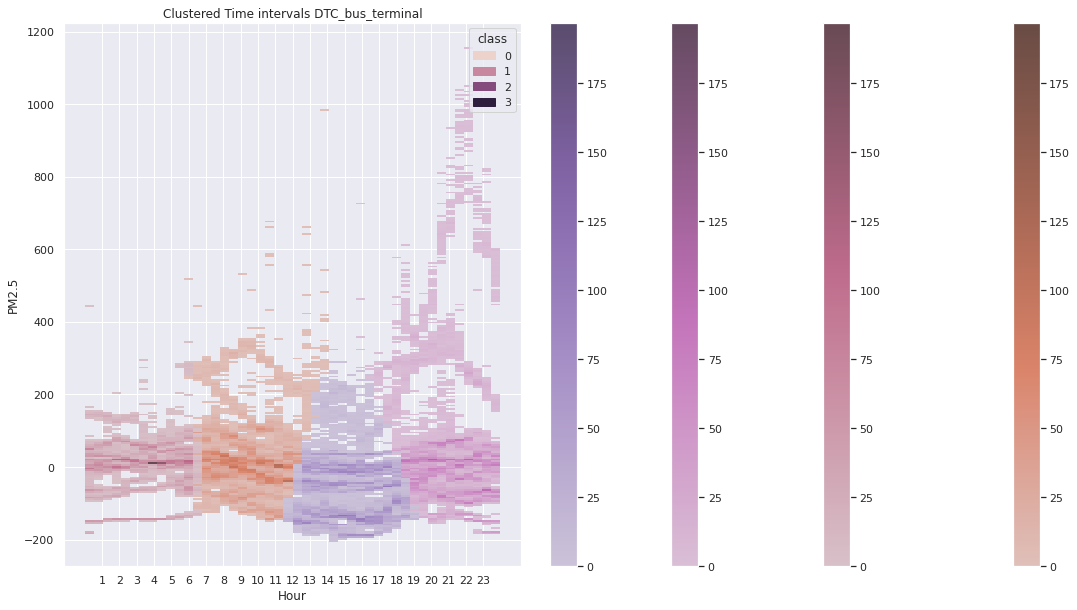

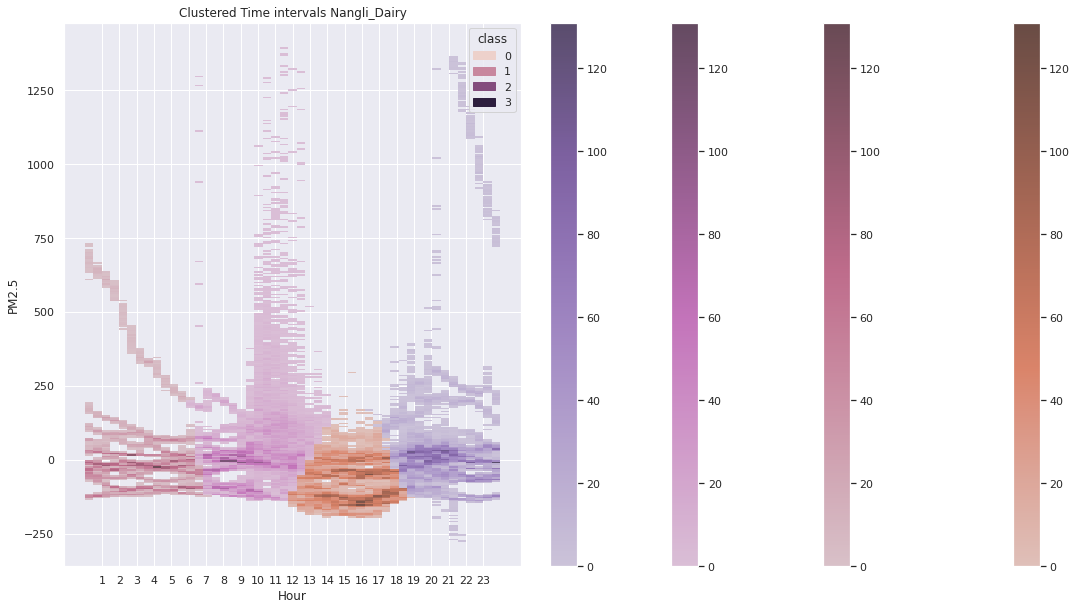

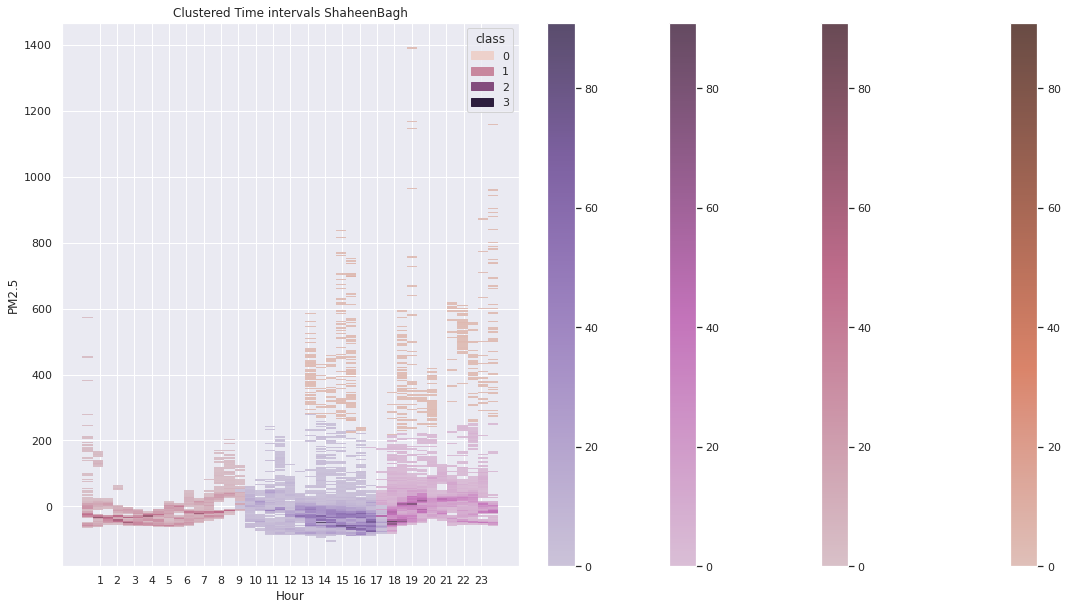

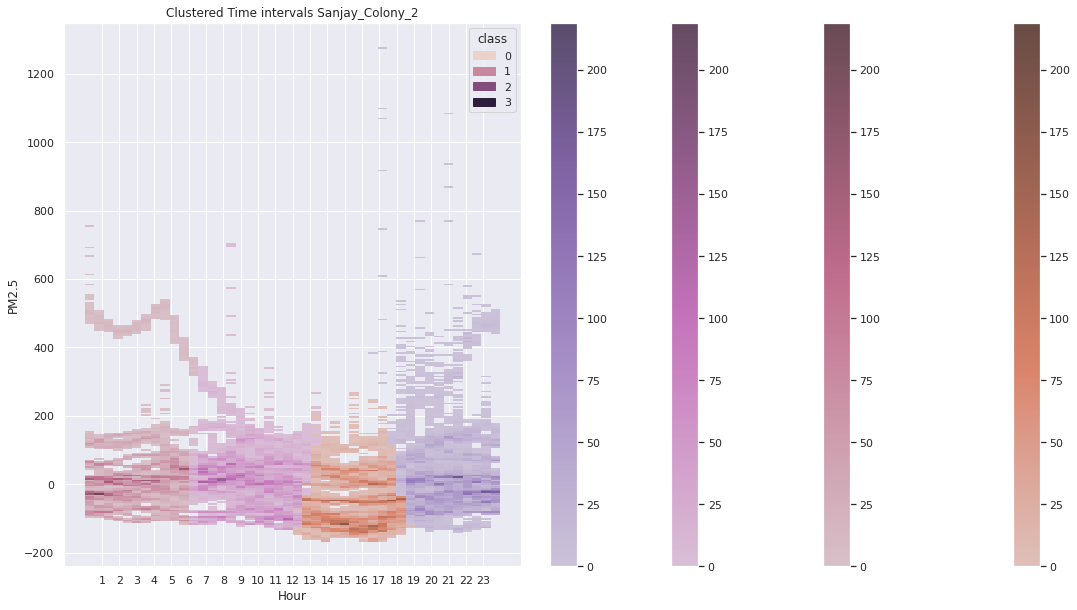

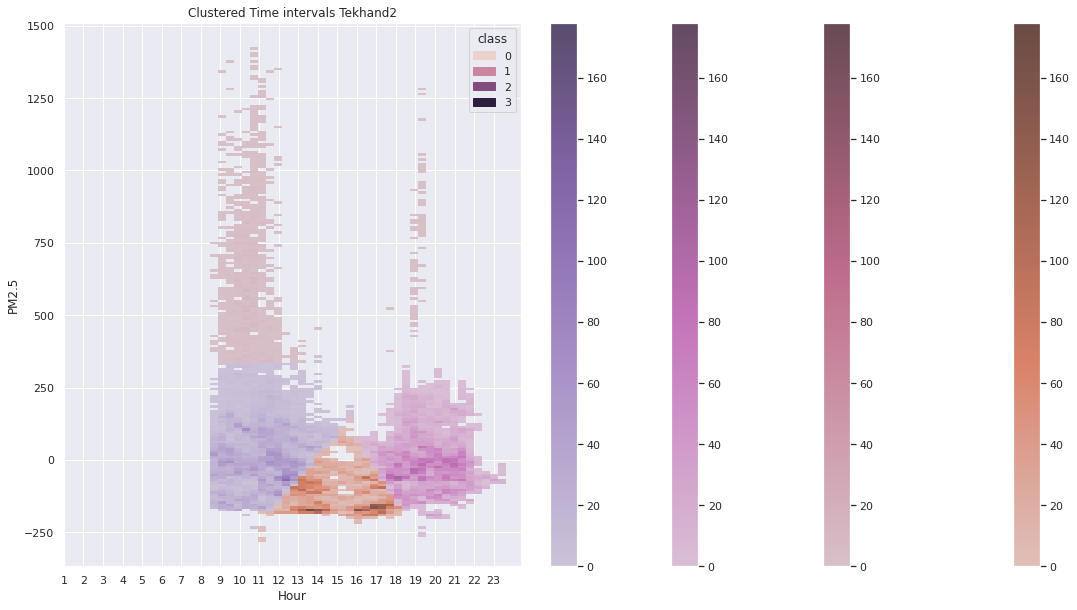

In [252]:
res = None
NUM_CLUSTERS = 4
CLUSTER_SCALING = 50
for i in sensorlocations:
    
    vx1 = allData[i]['fractionalDay']
    vx2 = allData[i]['pm2_5']
    vx3 = allData[i]['pm10']
    vx4 = allData[i]['pm1_0']

    mask1 = ~np.isnan(vx1) & ~np.isnan(vx2)
    mask2 = ~np.isnan(vx1) & ~np.isnan(vx3)
    mask3 = ~np.isnan(vx1) & ~np.isnan(vx4)
    s1, i1, r_value, p_value, std_err = stats.linregress(vx1[mask1],vx2[mask1])
    
    s2, i2, r_value, p_value, std_err = stats.linregress(vx1[mask2],vx3[mask2])
    
    s3, i3, r_value, p_value, std_err = stats.linregress(vx1[mask3],vx4[mask3])
    
    allData[i]["integerTimeScaled"] = allData[i]["integerTime"]*24.0 *CLUSTER_SCALING
    allData[i]["deTrend_pm2_5"] = allData[i]["pm2_5"] - (i1+s1*allData[i]['fractionalDay'])

    df = allData[i].reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(20, 10))
    
#     sns.histplot(data=df, x="integerTimeScaled", y="deTrend_pm2_5", cbar=True)


#     ax.set(xlabel='Time (Hours)', ylabel='PM 2.5')
#     ax.set_title("Jharoda Kalan PM 2.5 average heatmap throughout a day")
#     plt.show()
    

    clusterData1 = pd.DataFrame({
    'deTrend_pm2_5': df["deTrend_pm2_5"],
    'integerTimeScaled':df["integerTimeScaled"], 
    })
    km = KMeans(n_clusters=NUM_CLUSTERS)
    km.fit(clusterData1)
    labels = km.labels_

    res = pd.DataFrame(data=labels, columns=['cluster'], index=allData[i].index)
    
    res = res.reset_index(drop=True)
    clusterData1["class"] = res["cluster"]
    fig, ax = plt.subplots(figsize=(20, 10))
    
    g = sns.histplot(data=clusterData1, x="integerTimeScaled", y="deTrend_pm2_5", hue="class",cbar=True)
    
    xticklabels = list(map(lambda d: d, range(1,24)))
    x_ticks = list(map(lambda d: d*CLUSTER_SCALING, range(1,24)))

    g.set_xticks(x_ticks)
    g.set_xticklabels(xticklabels)
    
    ax.set(xlabel='Hour', ylabel='PM2.5')
    ax.set_title("Clustered Time intervals " + i)
    
    plt.show()


In [6]:
ROLL_MEAN_POINTS1 = 3600
ROLL_MEAN_POINTS2 = 16
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
# sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
for locs in sensorlocations:
    for i in sensorParameters:
        allData[locs]["roll_" + i] = allData[locs][i].rolling(ROLL_MEAN_POINTS1).mean().shift(-ROLL_MEAN_POINTS1//2)
for locs in cpcbLocations:
    for i in ["pm2_5","pm10"]:
        allData[locs]["roll_" + i] = allData[locs][i].rolling(ROLL_MEAN_POINTS2).mean().shift(-ROLL_MEAN_POINTS2//2)

najafgarh 160.0166516651665


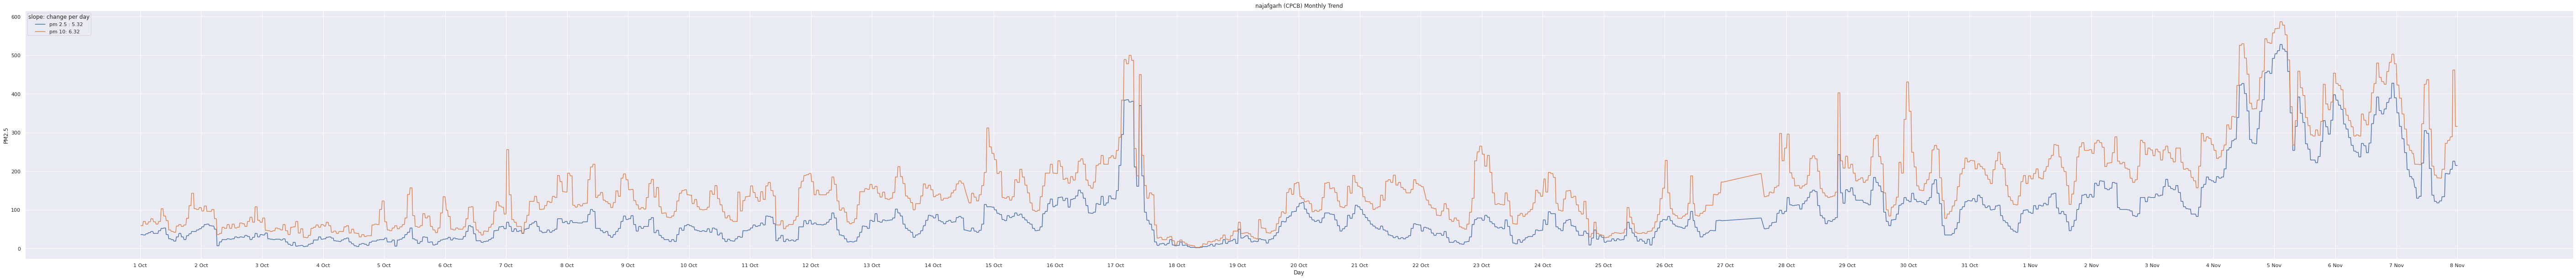

okhla 225.93892294220666


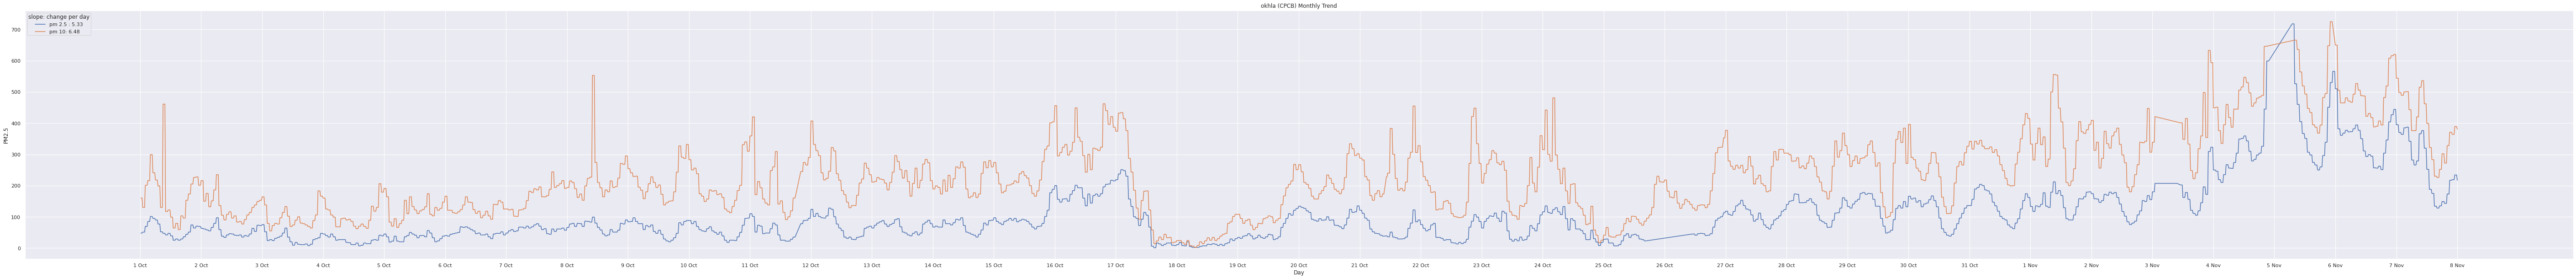

In [11]:
# fig, ax = plt.subplots(6,1,figsize=(30,60))
cpcbLocations = ["najafgarh","okhla"]
for i in cpcbLocations:
    x_ticks = map(lambda d: str(int(d))+' Oct' if d < 32.0 else str(int(d)-31)+' Nov', range(1,40))
    fig, ax = plt.subplots(figsize=(100, 10))
    vx1 = allData[i]['fractionalDay']
    vx2 = allData[i]['roll_pm2_5']
    vx3 = allData[i]['roll_pm10']
    mask1 = ~np.isnan(vx1) & ~np.isnan(vx2)
    mask2 = ~np.isnan(vx1) & ~np.isnan(vx3)
    s1, i1, r_value, p_value, std_err = stats.linregress(vx1[mask1],vx2[mask1])
    
    s2, i2, r_value, p_value, std_err = stats.linregress(vx1[mask2],vx3[mask2])

    print(i,vx3.mean())
    
#     print(i,"{:.2f}".format(s1),"{:.2f}".format(s2))
    
    g = sns.lineplot(x="fractionalDay", y="pm2_5", data=allData[i],ax=ax, label="pm 2.5 : "+"{:.2f}".format(s1))
    g = sns.lineplot(x="fractionalDay", y="pm10", data=allData[i],ax=ax, label="pm 10: "+"{:.2f}".format(s2))
    g.set_xticks(range(1,40))
    g.set_xticklabels(x_ticks)
    g.legend(title='slope: change per day',loc='upper left', borderpad=.2)
    ax.set(xlabel='Day', ylabel='PM2.5')
    ax.set_title(i+" (CPCB) Monthly Trend")
    plt.show()

Jharoda_Kalan 7.49 8.92 3.85


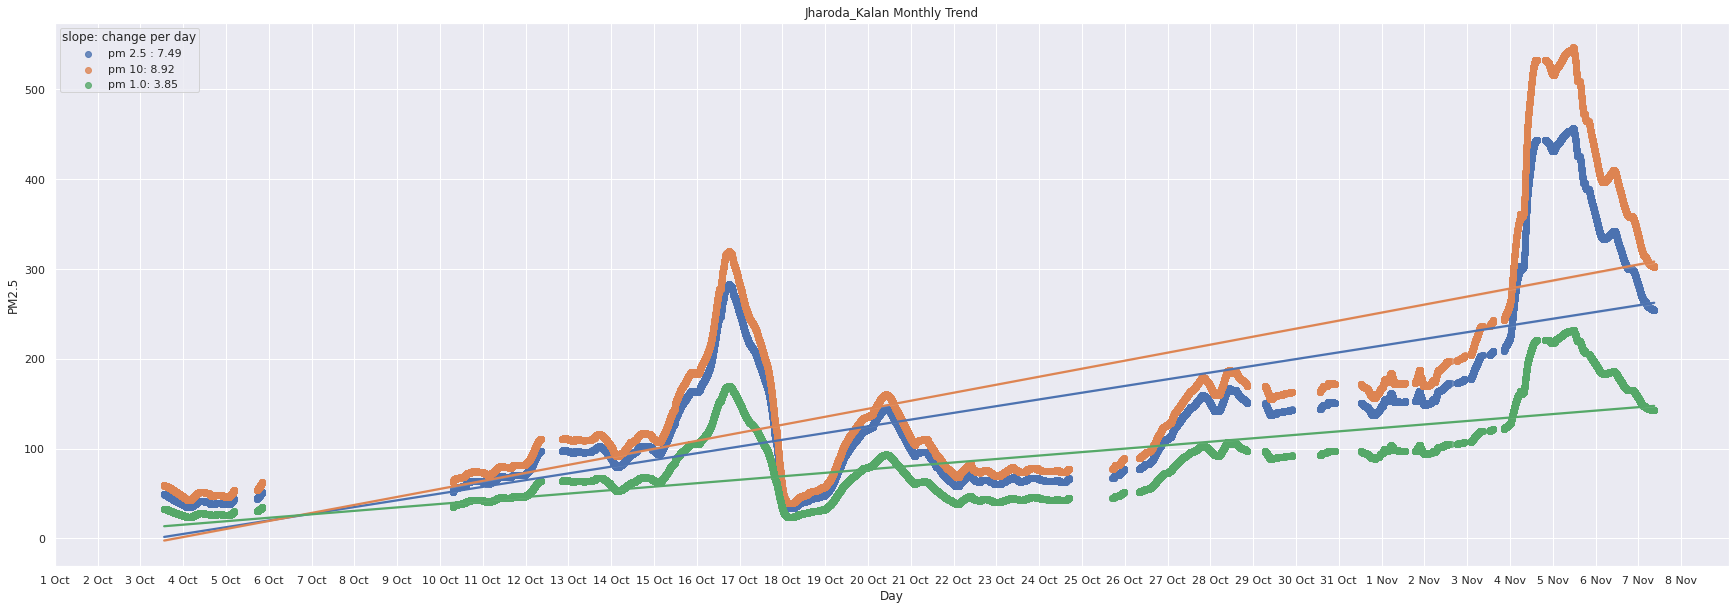

DTC_bus_terminal 8.05 9.22 4.32


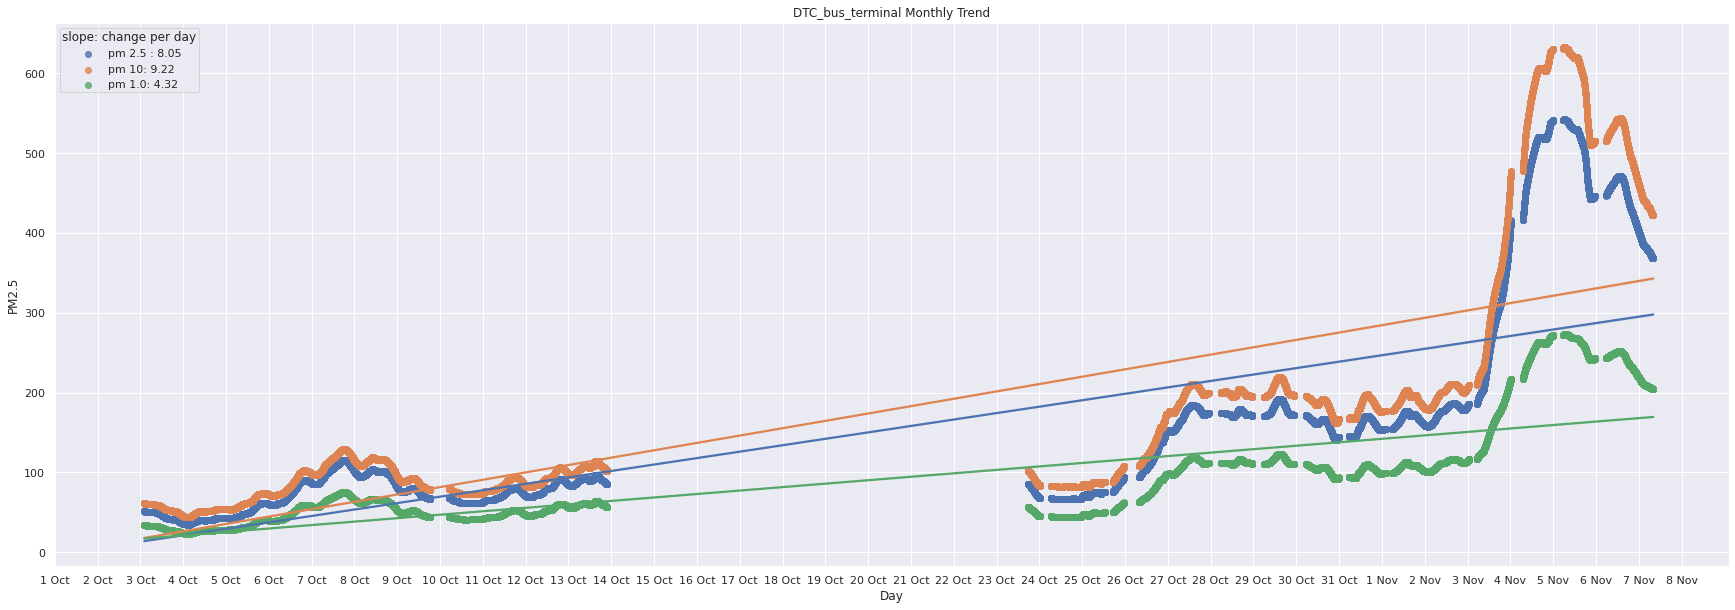

Nangli_Dairy 8.23 9.30 4.36


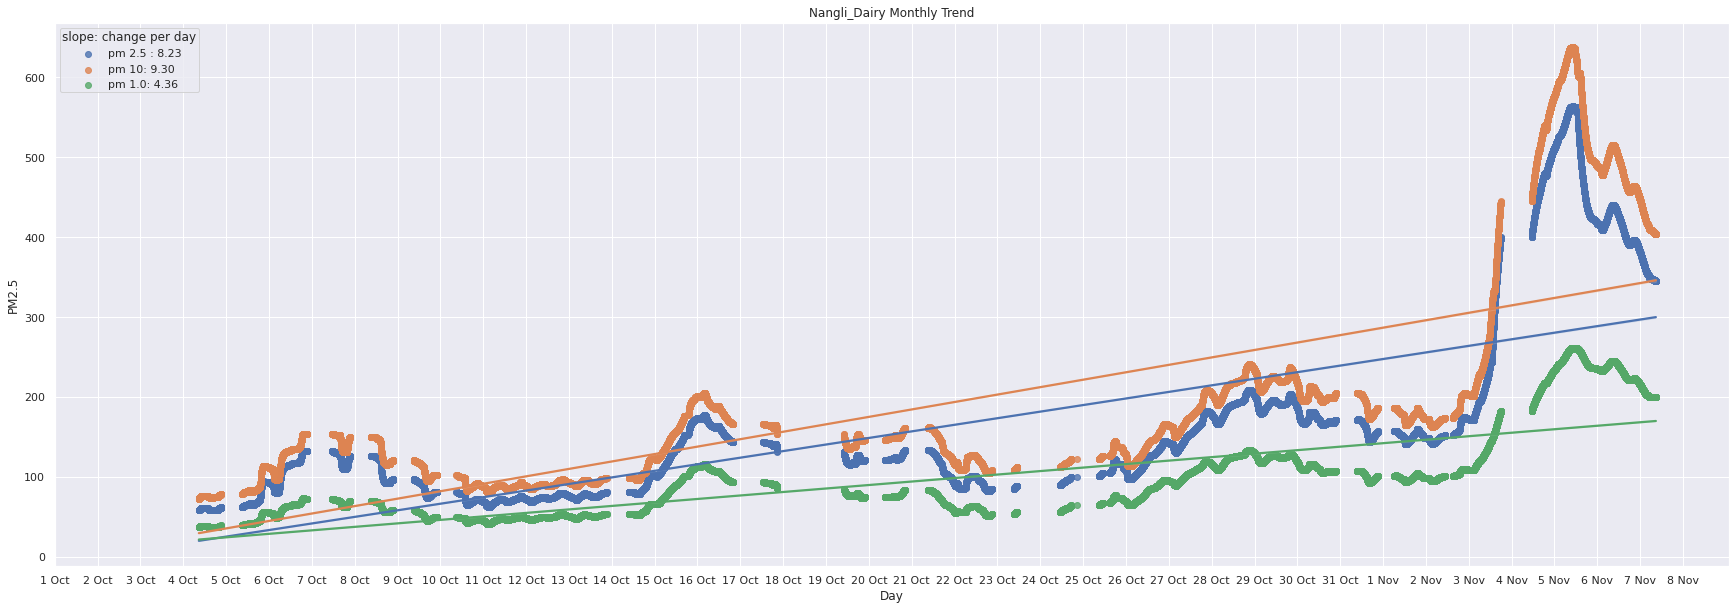

ShaheenBagh 1.38 1.33 1.12


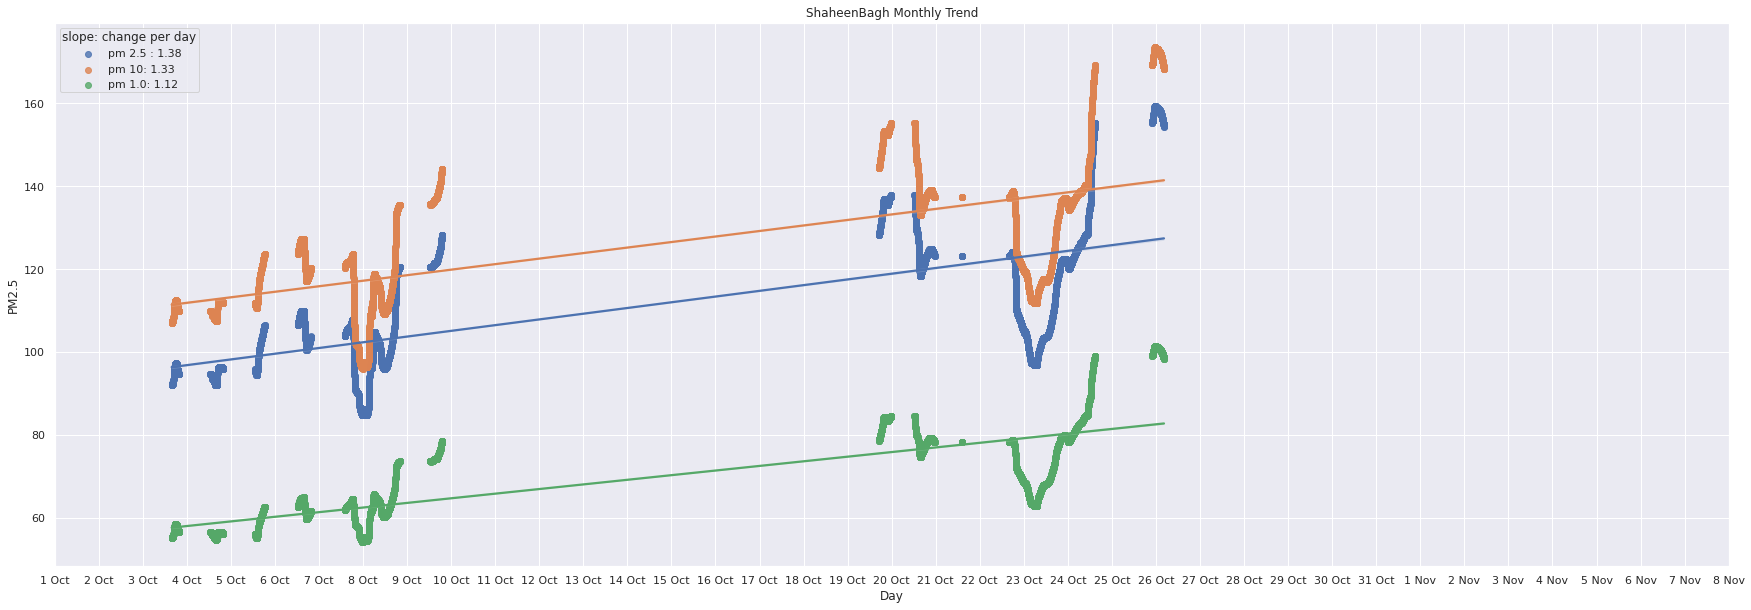

Sanjay_Colony_2 7.38 8.59 4.07


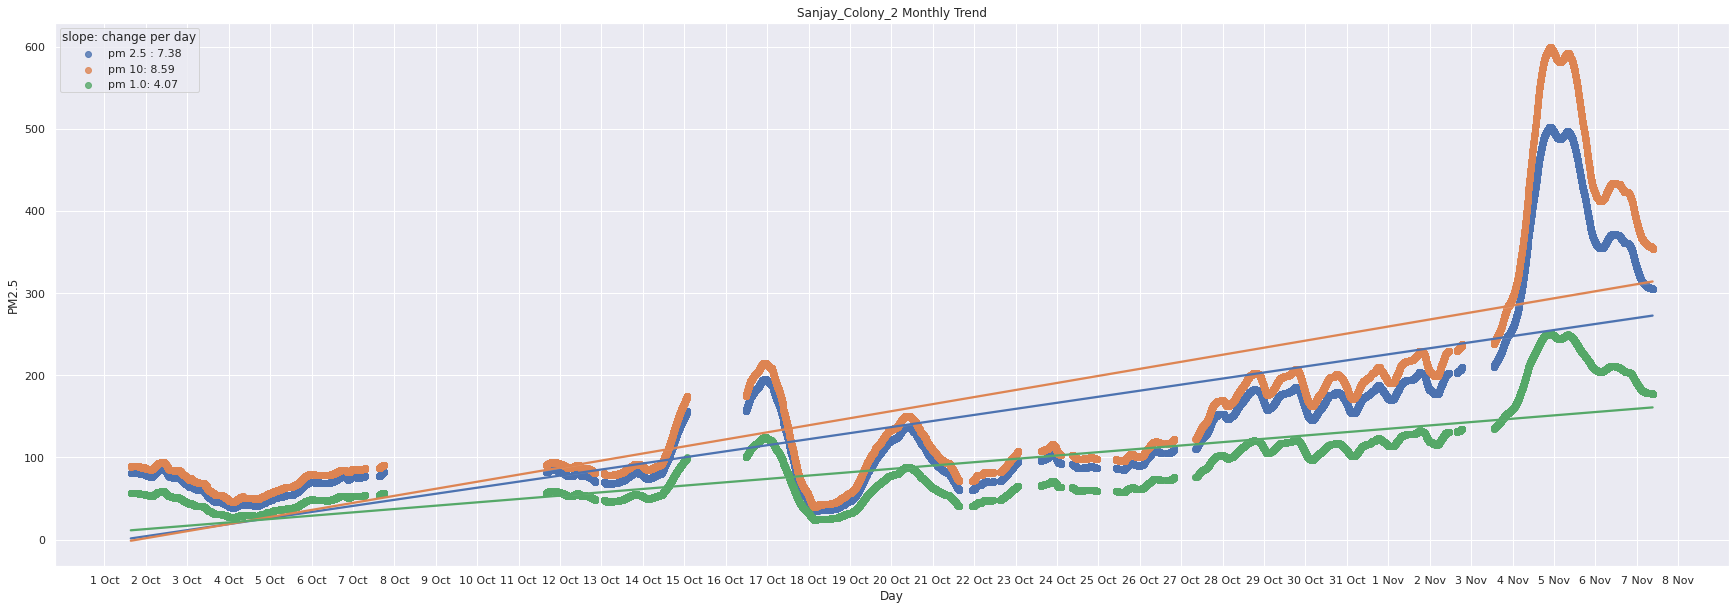

Tekhand2 5.93 6.60 2.73


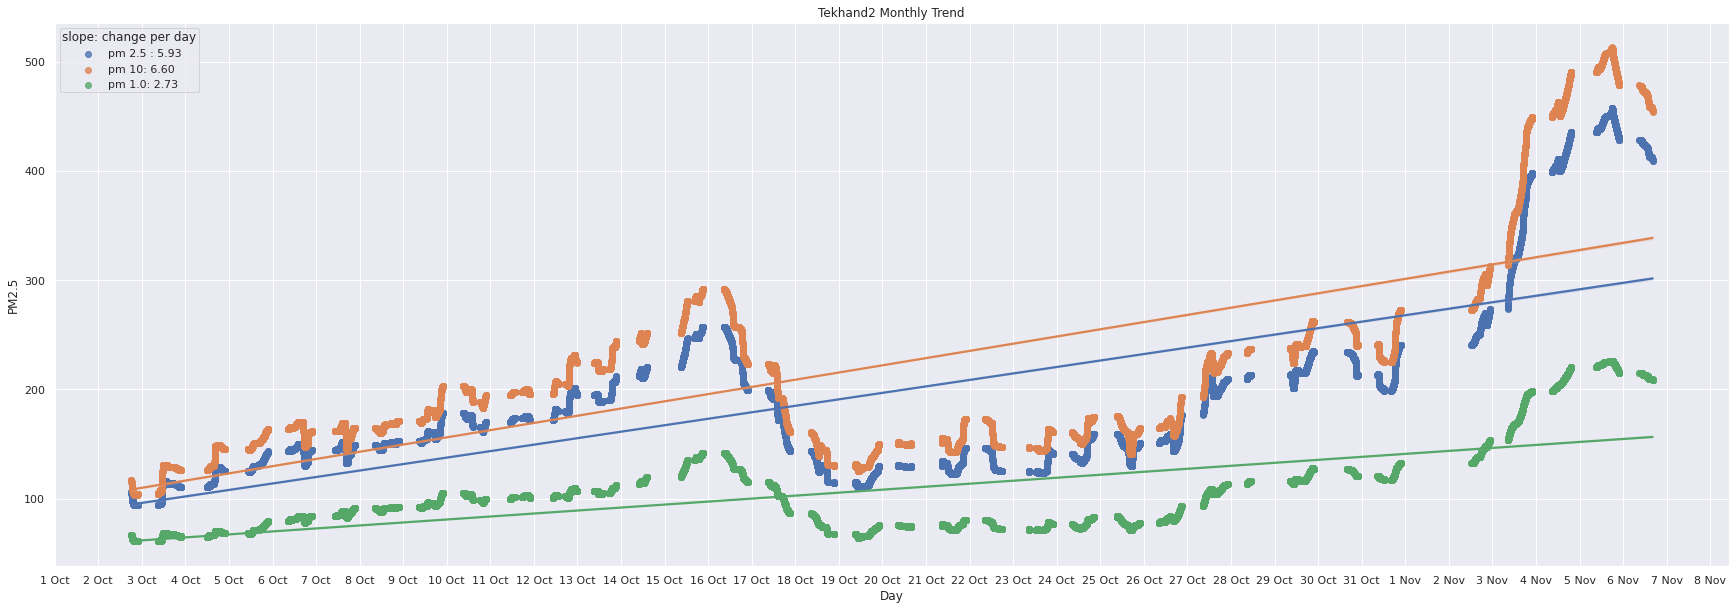

In [42]:
# fig, ax = plt.subplots(6,1,figsize=(30,60))
for i in range(6):
    x_ticks = map(lambda d: str(int(d))+' Oct' if d < 32.0 else str(int(d)-31)+' Nov', range(1,40))
    fig, ax = plt.subplots(figsize=(30, 10))
    vx1 = allData[sensorlocations[i]]['fractionalDay']
    vx2 = allData[sensorlocations[i]]['roll_pm2_5']
    vx3 = allData[sensorlocations[i]]['roll_pm10']
    vx4 = allData[sensorlocations[i]]['roll_pm1_0']
#     print(len(vx1),len(vx2),len(vx3),len(vx4))
    mask1 = ~np.isnan(vx1) & ~np.isnan(vx2)
    mask2 = ~np.isnan(vx1) & ~np.isnan(vx3)
    mask3 = ~np.isnan(vx1) & ~np.isnan(vx4)
    s1, i1, r_value, p_value, std_err = stats.linregress(vx1[mask1],vx2[mask1])
    
    s2, i2, r_value, p_value, std_err = stats.linregress(vx1[mask2],vx3[mask2])
    
    s3, i3, r_value, p_value, std_err = stats.linregress(vx1[mask3],vx4[mask3])
    
    print(sensorlocations[i],"{:.2f}".format(s1),"{:.2f}".format(s2),"{:.2f}".format(s3))
    g = sns.regplot(x="fractionalDay", y="roll_pm2_5", data=allData[sensorlocations[i]],ax=ax, label="pm 2.5 : "+"{:.2f}".format(s1))
    g = sns.regplot(x="fractionalDay", y="roll_pm10", data=allData[sensorlocations[i]],ax=ax, label="pm 10: "+"{:.2f}".format(s2))
    g = sns.regplot(x="fractionalDay", y="roll_pm1_0", data=allData[sensorlocations[i]],ax=ax, label="pm 1.0: "+"{:.2f}".format(s3))
    g.set_xticks(range(1,40))
    g.set_xticklabels(x_ticks)
    g.legend(title='slope: change per day',loc='upper left', borderpad=.2)
    ax.set(xlabel='Day', ylabel='PM2.5')
    ax.set_title(sensorlocations[i]+" Monthly Trend")
    plt.show()

In [80]:
s = s1d
(s - s1a).mean(),np.sqrt(((s - s1a) ** 2).mean())

(14.582269958690738, 74.12082597053511)

                  najafgarh(CPCB)  DTC_bus_terminal  Jharoda_Kalan  \
najafgarh(CPCB)          1.000000          0.920263       0.879288   
DTC_bus_terminal         0.920263          1.000000       0.955033   
Jharoda_Kalan            0.879288          0.955033       1.000000   
Nangli_Dairy             0.876231          0.931903       0.877278   

                  Nangli_Dairy  
najafgarh(CPCB)       0.876231  
DTC_bus_terminal      0.931903  
Jharoda_Kalan         0.877278  
Nangli_Dairy          1.000000  


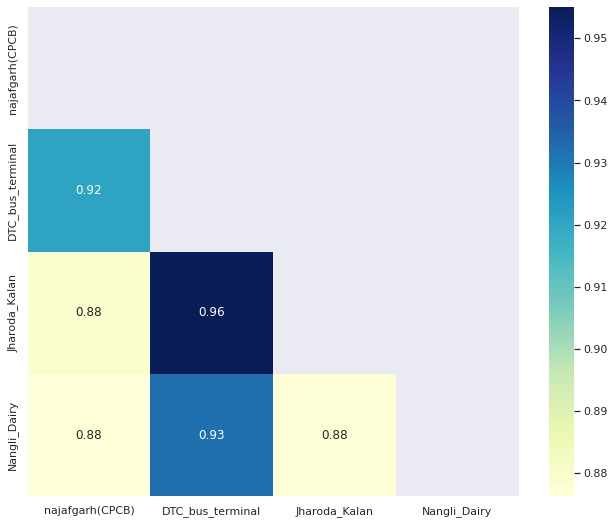

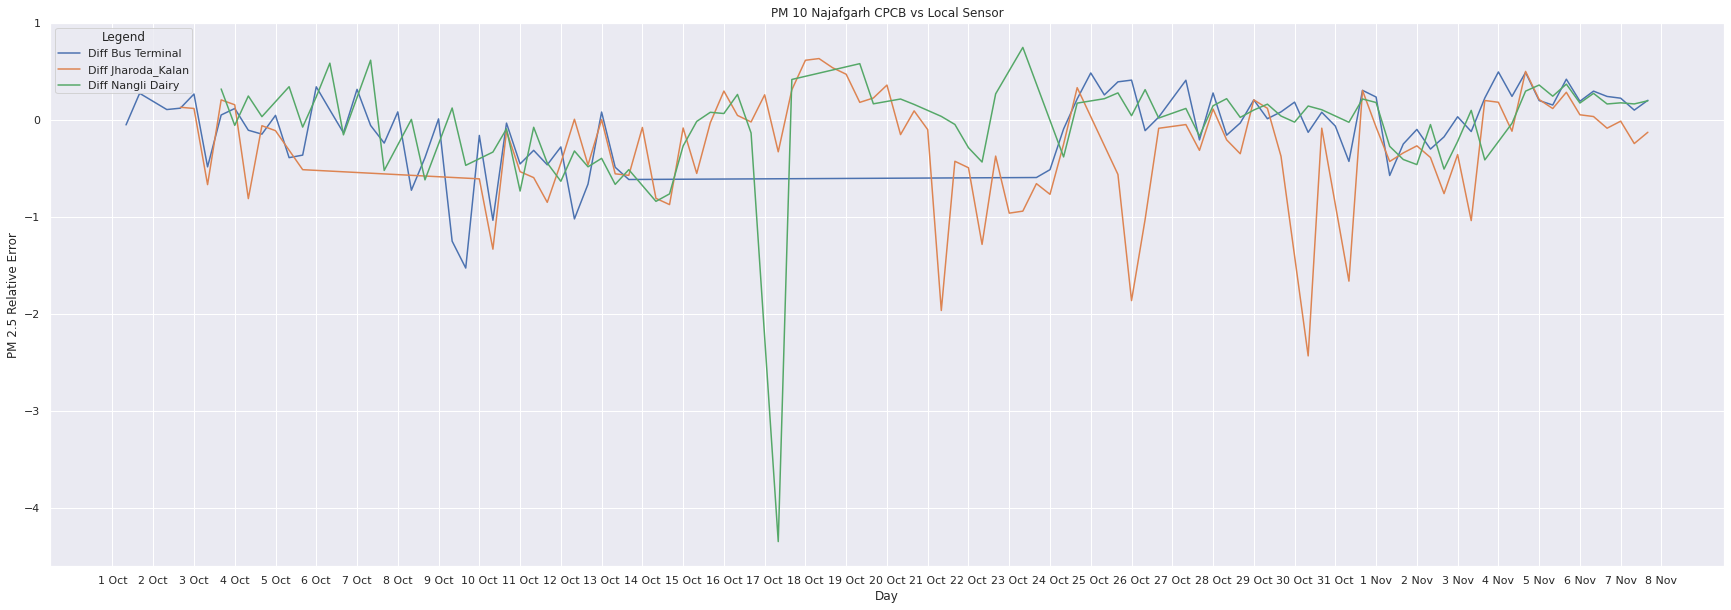

In [76]:
RESAMPLE_BY = '8H'
PARAM = "pm10"
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]

def getIntForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    return (timeFromStart) / 24.0
def getFractionalDayForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    fractionDay = (timeFromStart) / 24.0
    if(row["timestamp"].month==10):
        return row["timestamp"].day + fractionDay
    else:
        return 31.0 + row["timestamp"].day + fractionDay
    
s1a = allData["najafgarh"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)
s1b = allData["DTC_bus_terminal"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)
s1c = allData["Jharoda_Kalan"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)
s1d = allData["Nangli_Dairy"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)

d1b = (s1b - s1a)/s1b
d1c = (s1c - s1a)/s1c
d1d = (s1d - s1a)/s1d

df1 = pd.DataFrame({
    'najafgarh(CPCB)': s1a,
    'DTC_bus_terminal':s1b, 
    'Diff_Bus_Terminal':d1b,
    'Jharoda_Kalan':s1c, 
    'Diff_Jharoda_Kalan':d1c,
    'Nangli_Dairy':s1d, 
    'Diff_Nangli_Dairy':d1d,
})

df1["timestamp"] = df1.index
df1.loc[:,"integerTime"] = df1.apply(lambda row: getIntForTimeDate(row), axis=1)
df1.loc[:,"fractionalDay"] = df1.apply(lambda row: getFractionalDayForTimeDate(row), axis=1)

cor1 = pd.DataFrame({
    'najafgarh(CPCB)': s1a,
    'DTC_bus_terminal':s1b, 
    'Jharoda_Kalan':s1c, 
    'Nangli_Dairy':s1d, 
})

corr1 = cor1.corr()
print(corr1)
mask = np.triu(np.ones_like(corr1, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr1, mask=mask,cmap="YlGnBu", annot=True)

plt.show()

x_ticks = map(lambda d: str(int(d))+' Oct' if d < 32.0 else str(int(d)-31)+' Nov', range(1,40))
fig, ax = plt.subplots(figsize=(30, 10))
g = sns.lineplot(x="fractionalDay", y="Diff_Bus_Terminal", data=df1,ax=ax, label="Diff Bus Terminal")
g = sns.lineplot(x="fractionalDay", y="Diff_Jharoda_Kalan", data=df1,ax=ax, label="Diff Jharoda_Kalan")
g = sns.lineplot(x="fractionalDay", y="Diff_Nangli_Dairy", data=df1,ax=ax, label="Diff Nangli Dairy")
g.set_xticks(range(1,40))
g.set_xticklabels(x_ticks)
g.legend(title='Legend',loc='upper left', borderpad=.2)
ax.set(xlabel='Day', ylabel='PM 2.5 Relative Error')
ax.set_title("PM 10 Najafgarh CPCB vs Local Sensor")
plt.show()
    
# # s2a = allData["okhla"]["pm2_5"].resample(RESAMPLE_BY).mean()
# # s2b = allData["ShaheenBagh"]["pm2_5"].resample(RESAMPLE_BY).mean()
# # s2c = allData["Sanjay_Colony_2"]["pm2_5"].resample(RESAMPLE_BY).mean()
# # s2d = allData["Tekhand2"]["pm2_5"].resample(RESAMPLE_BY).mean()



In [89]:
s = s1d
(s - s1a).mean(),np.sqrt(((s - s1a) ** 2).mean())

(-2.7748443862967673, 79.87559293501171)

                 najafgarh(CPCB)  ShaheenBagh  Sanjay_Colony_2  Tekhand2
najafgarh(CPCB)         1.000000     0.313624         0.886952  0.797068
ShaheenBagh             0.313624     1.000000         0.480856  0.316216
Sanjay_Colony_2         0.886952     0.480856         1.000000  0.830216
Tekhand2                0.797068     0.316216         0.830216  1.000000


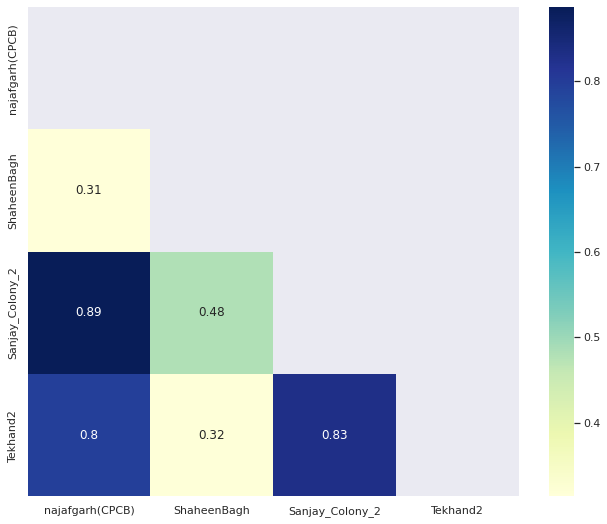

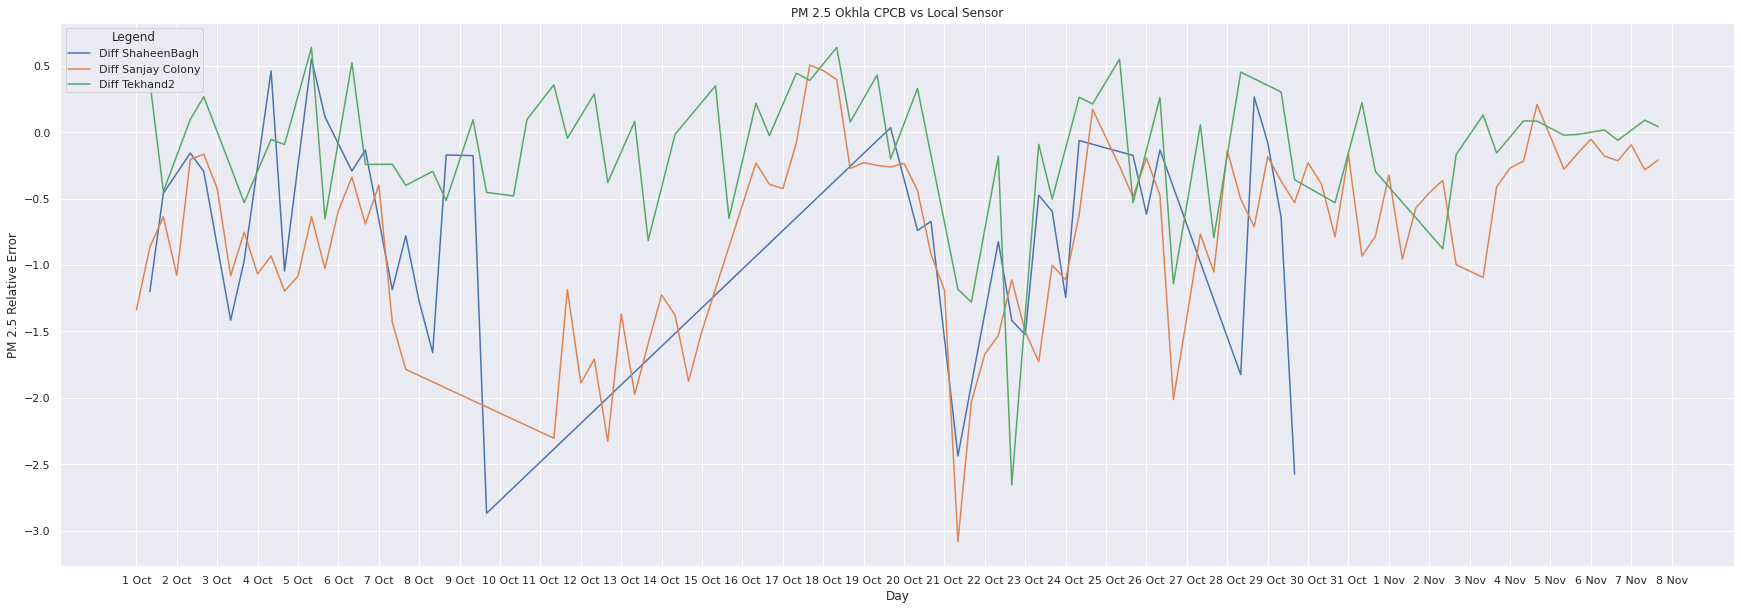

In [274]:
RESAMPLE_BY = '8H'
PARAM = "pm10"
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]

def getIntForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    return (timeFromStart) / 24.0
def getFractionalDayForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    fractionDay = (timeFromStart) / 24.0
    if(row["timestamp"].month==10):
        return row["timestamp"].day + fractionDay
    else:
        return 31.0 + row["timestamp"].day + fractionDay
    
s1a = allData["okhla"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)
s1b = allData["ShaheenBagh"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)
s1c = allData["Sanjay_Colony_2"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)
s1d = allData["Tekhand2"][PARAM].resample(RESAMPLE_BY).mean().tz_localize(None)

d1b = (s1b - s1a)/s1b
d1c = (s1c - s1a)/s1c
d1d = (s1d - s1a)/s1d

df1 = pd.DataFrame({
    'okhla(CPCB)': s1a,
    'ShaheenBagh':s1b, 
    'Diff_ShaheenBagh':d1b,
    'Sanjay_Colony_2':s1c, 
    'Diff_Sanjay_Colony_2':d1c,
    'Tekhand2':s1d, 
    'Diff_Tekhand2':d1d,
})

df1["timestamp"] = df1.index
df1.loc[:,"integerTime"] = df1.apply(lambda row: getIntForTimeDate(row), axis=1)
df1.loc[:,"fractionalDay"] = df1.apply(lambda row: getFractionalDayForTimeDate(row), axis=1)

cor1 = pd.DataFrame({
    'najafgarh(CPCB)': s1a,
    'ShaheenBagh':s1b, 
    'Sanjay_Colony_2':s1c, 
    'Tekhand2':s1d, 
})

corr1 = cor1.corr()
print(corr1)
mask = np.triu(np.ones_like(corr1, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr1, mask=mask,cmap="YlGnBu", annot=True)

plt.show()

x_ticks = map(lambda d: str(int(d))+' Oct' if d < 32.0 else str(int(d)-31)+' Nov', range(1,40))
fig, ax = plt.subplots(figsize=(30, 10))
g = sns.lineplot(x="fractionalDay", y="Diff_ShaheenBagh", data=df1,ax=ax, label="Diff ShaheenBagh")
g = sns.lineplot(x="fractionalDay", y="Diff_Sanjay_Colony_2", data=df1,ax=ax, label="Diff Sanjay Colony")
g = sns.lineplot(x="fractionalDay", y="Diff_Tekhand2", data=df1,ax=ax, label="Diff Tekhand2")
g.set_xticks(range(1,40))
g.set_xticklabels(x_ticks)
g.legend(title='Legend',loc='upper left', borderpad=.2)
ax.set(xlabel='Day', ylabel='PM 2.5 Relative Error')
ax.set_title("PM 2.5 Okhla CPCB vs Local Sensor")
plt.show()
    
# # s2a = allData["okhla"]["pm2_5"].resample(RESAMPLE_BY).mean()
# # s2b = allData["ShaheenBagh"]["pm2_5"].resample(RESAMPLE_BY).mean()
# # s2c = allData["Sanjay_Colony_2"]["pm2_5"].resample(RESAMPLE_BY).mean()
# # s2d = allData["Tekhand2"]["pm2_5"].resample(RESAMPLE_BY).mean()



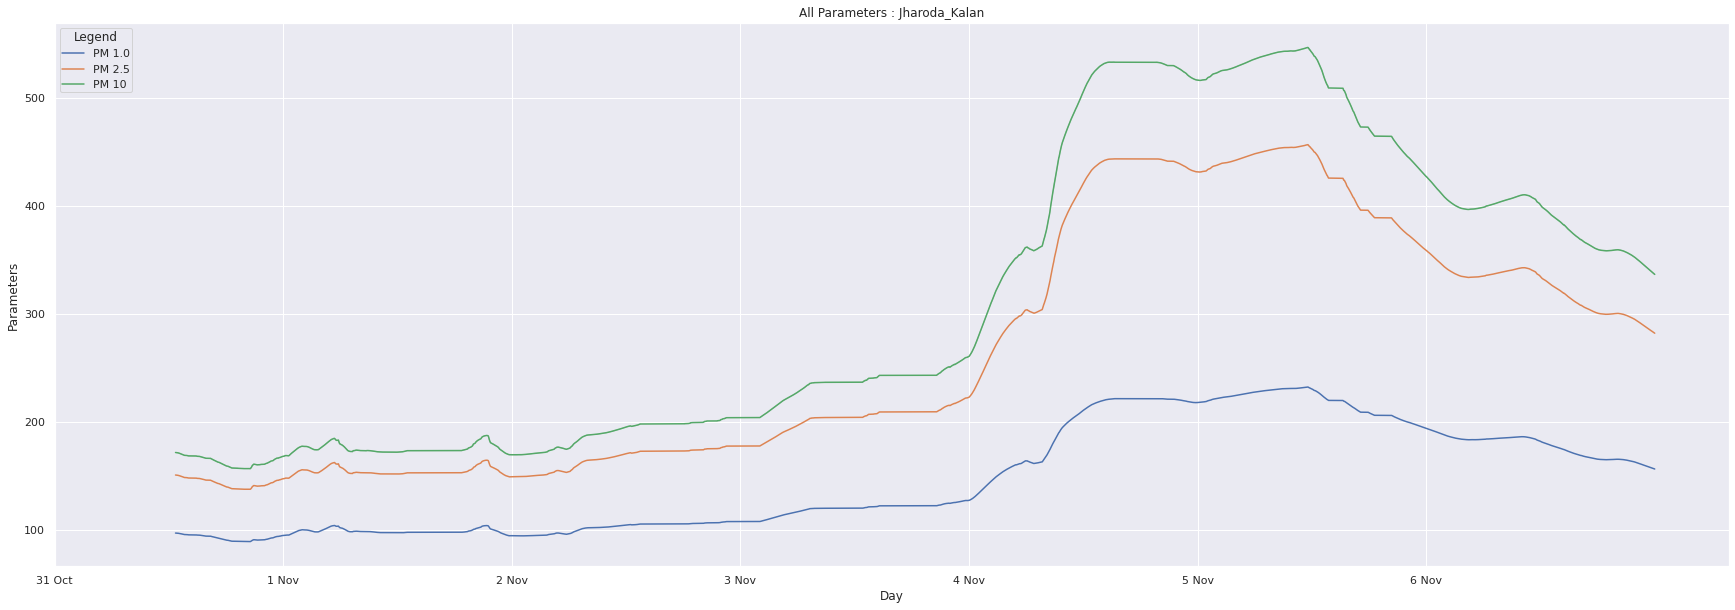

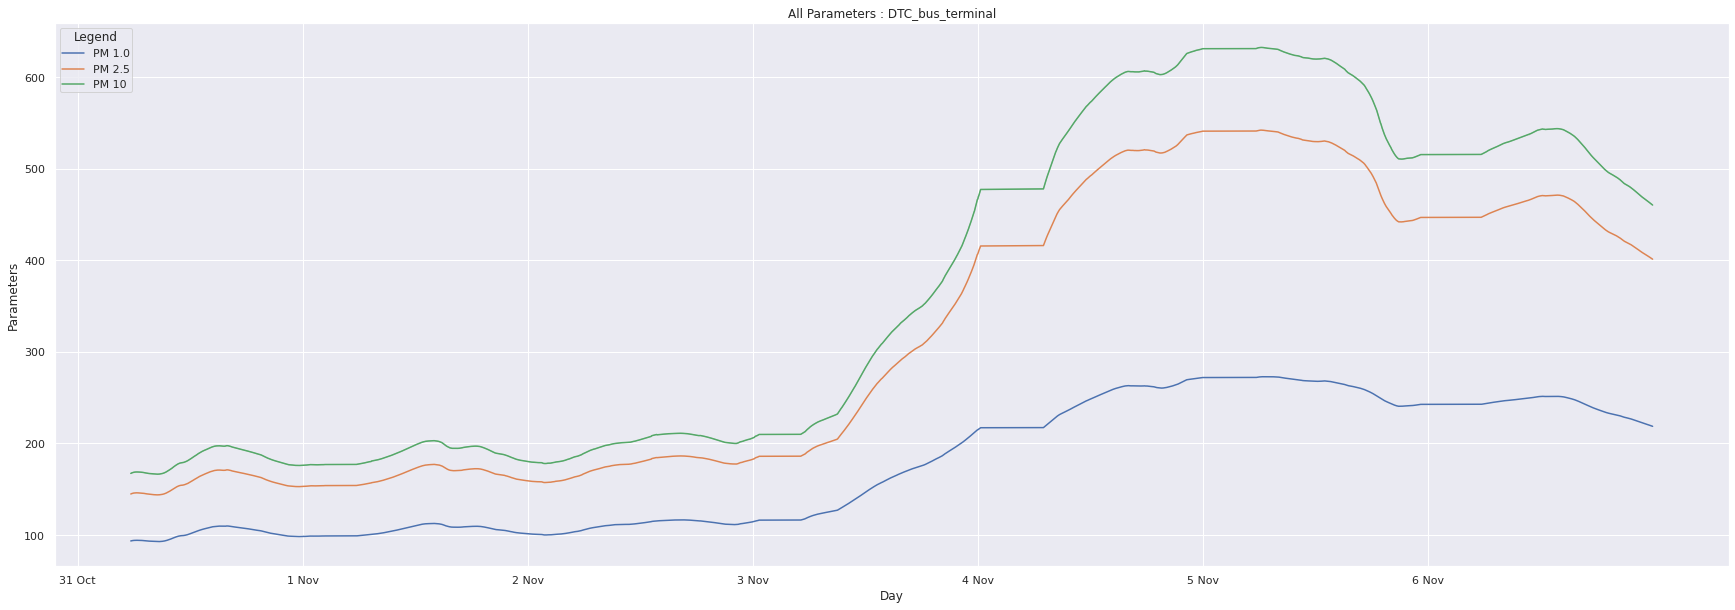

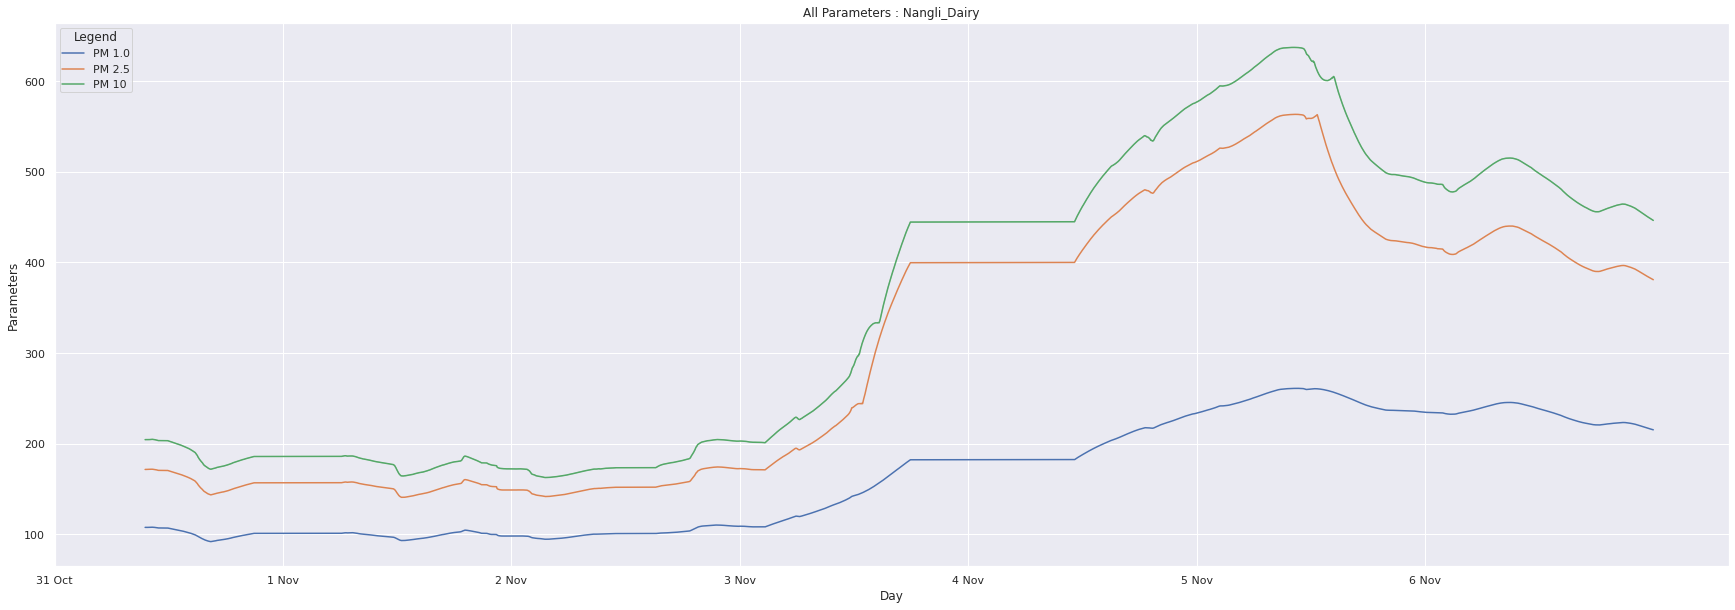

No handles with labels found to put in legend.


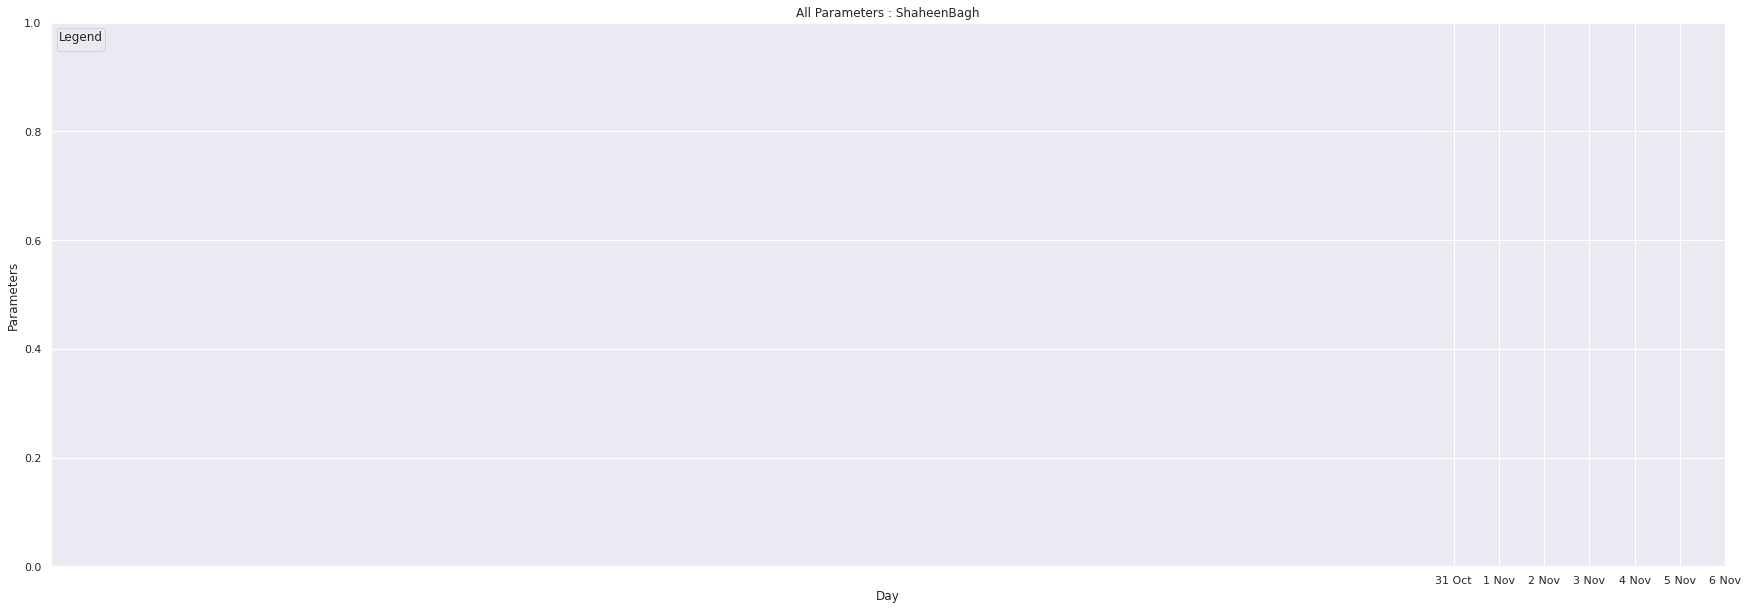

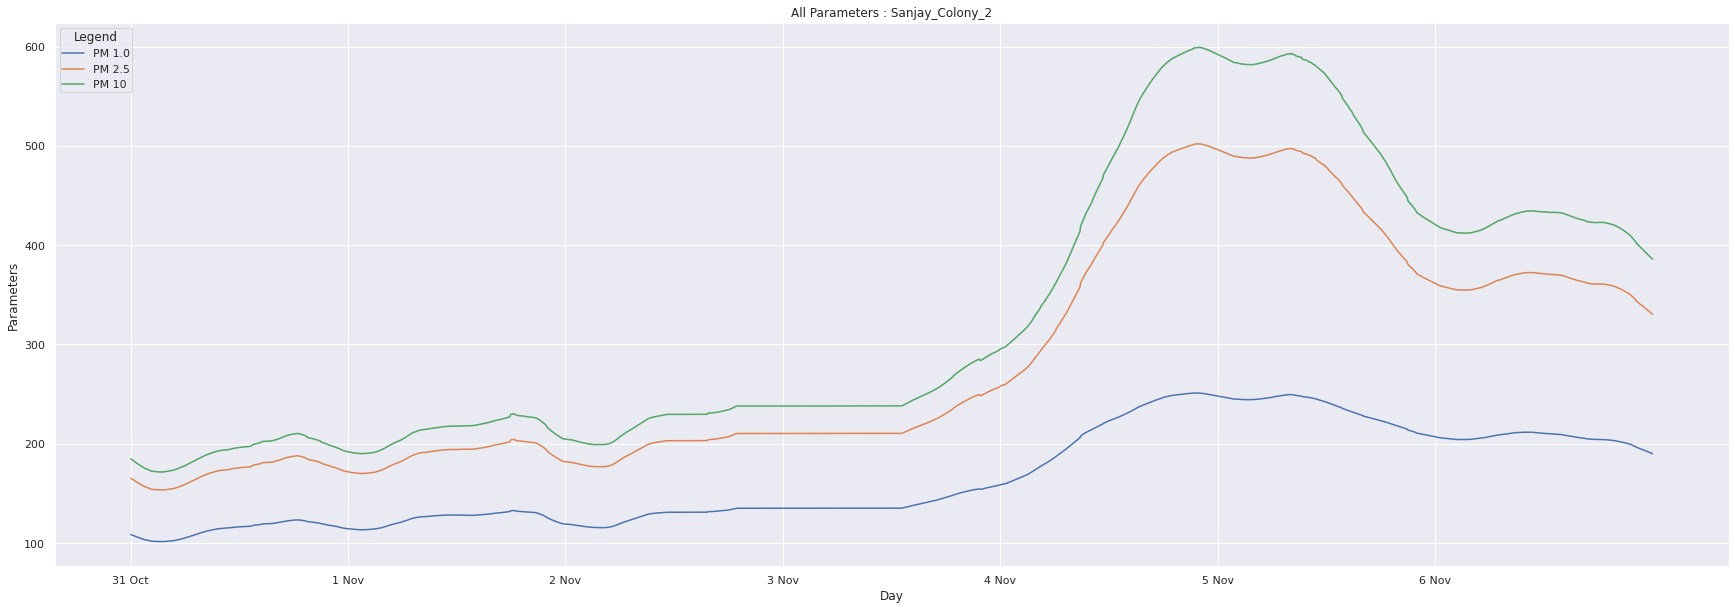

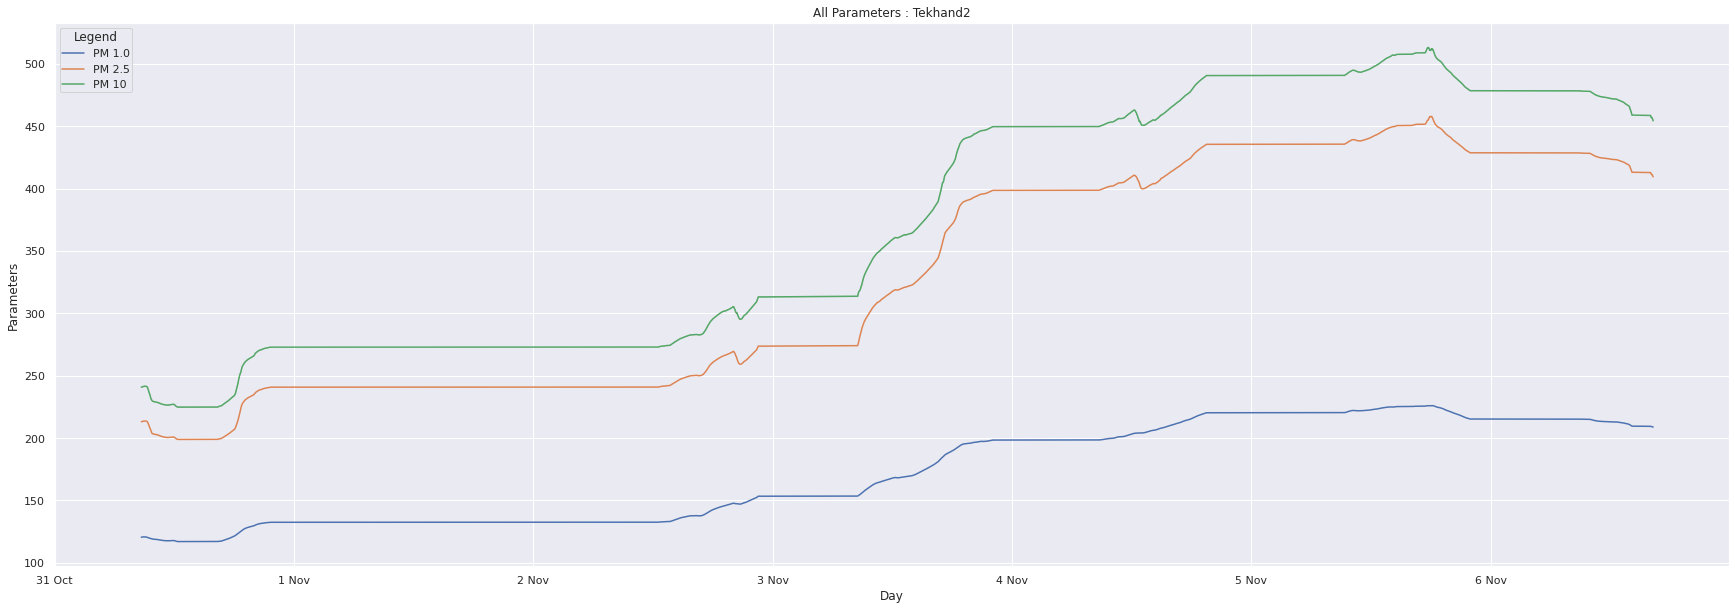

In [9]:
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
for loc in sensorlocations:
#     loc = "Jharoda_Kalan"
    df1 = allData[loc]
    mask = (df1['fractionalDay'] > 31) & (df1['fractionalDay'] <= 38)
    df = df1[mask].copy()
    df = df.reset_index(drop=True)
    x_ticks = map(lambda d: str(int(d))+' Oct' if d < 32.0 else str(int(d)-31)+' Nov', range(31,38))
    print(x_ticks)
    fig, ax = plt.subplots(figsize=(30, 10))
    g = sns.lineplot(x="fractionalDay", y="roll_pm1_0", data=df,ax=ax, label="PM 1.0",ci=None)
    g = sns.lineplot(x="fractionalDay", y="roll_pm2_5", data=df,ax=ax, label="PM 2.5",ci=None)
    g = sns.lineplot(x="fractionalDay", y="roll_pm10", data=df,ax=ax, label="PM 10")
    g.set_xticks(range(31,38))
    g.set_xticklabels(x_ticks)
    g.legend(title='Legend',loc='upper left', borderpad=.2)
    ax.set(xlabel='Day', ylabel='Parameters')
    ax.set_title("All Parameters : "+loc)
    plt.show()
